# Proyek Klasifikasi Gambar: Fast Food Classification
- **Nama:** Nicolas Debrito
- **Email:** nicolas.debrito66@gmail.com
- **ID Dicoding:** reezzy

## Import Semua Packages/Library yang Digunakan

In [1]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout, BatchNormalization, Input, Flatten, LeakyReLU, GlobalAveragePooling2D
from tensorflow.keras.applications import MobileNetV2, ResNet50V2
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.regularizers import l2
from collections import Counter
import kagglehub
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
import random, shutil
import pathlib

from warnings import filterwarnings
filterwarnings('ignore')

random.seed(42)

## Data Preparation

### Data Loading

Dataset diambil dari kaggle https://www.kaggle.com/datasets/utkarshsaxenadn/fast-food-classification-dataset

In [2]:
path = kagglehub.dataset_download("utkarshsaxenadn/fast-food-classification-dataset")
print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/fast-food-classification-dataset


In [3]:
dataset_dir = os.path.join(path, "Fast Food Classification V2", "Train")

In [4]:
def check_dataset_size(folder):
    folder_food_name = os.listdir(folder)
    image_count = 0

    for food_name in folder_food_name:
        image_count += len(os.listdir(f'{folder}/{food_name}'))

    return image_count

print("Jumlah gambar pada dataset adalah", check_dataset_size(dataset_dir))

Jumlah gambar pada dataset adalah 15000


In [5]:
print("Jumlah kelas pada dataset adalah", len(os.listdir(dataset_dir)))
print("Dengan nama kelas", ", ".join(os.listdir(dataset_dir)))

Jumlah kelas pada dataset adalah 10
Dengan nama kelas Donut, Sandwich, Hot Dog, Burger, Crispy Chicken, Fries, Baked Potato, Taco, Pizza, Taquito


In [6]:
def check_image_size(folder):
	folder_food_name = os.listdir(folder)
	size = []

	for food_name in folder_food_name:
		for image_name in os.listdir(f'{folder}/{food_name}'):
			try :
				image = mpimg.imread(f'{folder}/{food_name}/{image_name}')
				size.append(image.shape)
			except: pass

	return Counter(size)

image_check = check_image_size(dataset_dir)
image_check_df = pd.DataFrame(image_check.items(), columns=['Size', 'Count']).sort_values(by='Count', ascending=False)
image_check_df

,Size,Count
2,"(183, 275, 3)",2248
12,"(225, 225, 3)",2049
1,"(275, 183, 3)",1969
3,"(194, 259, 3)",1168
4,"(168, 300, 3)",948
...,...,...
576,"(162, 288, 3)",1
577,"(333, 152, 3)",1
255,"(280, 390, 3)",1
257,"(2643, 2643, 3)",1


In [7]:
source_directory = dataset_dir
destination_directory = './fastfood/dataset/'
split_ratio = {'train': 0.7, 'val': 0.15, 'test': 0.15}

for split in split_ratio:
    for class_name in os.listdir(source_directory):
        os.makedirs(os.path.join(destination_directory, split, class_name), exist_ok=True)

for class_name in os.listdir(source_directory):
    class_path = os.path.join(source_directory, class_name)
    images = os.listdir(class_path)
    random.shuffle(images)

    total = len(images)
    train_end = int(total * split_ratio['train'])
    val_end = train_end + int(total * split_ratio['val'])

    split_data = {
        'train': images[:train_end],
        'val': images[train_end:val_end],
        'test': images[val_end:]
    }

    for split in split_ratio:
        for img_file in split_data[split]:
            src = os.path.join(class_path, img_file)
            dst = os.path.join(destination_directory, split, class_name, img_file)
            shutil.copy(src, dst)

In [8]:
def check_image_per_split(dir):
    total_images = 0
    print(f"\nDetail jumlah gambar di {dir}:")
    for class_name in os.listdir(dir):
        class_path = os.path.join(dir, class_name)
        if os.path.isdir(class_path):
            num_images = len(os.listdir(class_path))
            print(f"- {class_name}: {num_images} images")
            total_images += num_images
    print(f"Total: {total_images} images")

In [9]:
train_dir = "./fastfood/dataset/train"
test_dir = "./fastfood/dataset/test"
val_dir = "./fastfood/dataset/val"

print(check_image_per_split(train_dir))
print(check_image_per_split(test_dir))
print(check_image_per_split(val_dir))


Detail jumlah gambar di ./fastfood/dataset/train:
- Taquito: 1050 images
- Baked Potato: 1050 images
- Crispy Chicken: 1050 images
- Hot Dog: 1050 images
- Pizza: 1050 images
- Taco: 1050 images
- Burger: 1050 images
- Fries: 1050 images
- Sandwich: 1050 images
- Donut: 1050 images
Total: 10500 images
None

Detail jumlah gambar di ./fastfood/dataset/test:
- Taquito: 225 images
- Baked Potato: 225 images
- Crispy Chicken: 225 images
- Hot Dog: 225 images
- Pizza: 225 images
- Taco: 225 images
- Burger: 225 images
- Fries: 225 images
- Sandwich: 225 images
- Donut: 225 images
Total: 2250 images
None

Detail jumlah gambar di ./fastfood/dataset/val:
- Taquito: 225 images
- Baked Potato: 225 images
- Crispy Chicken: 225 images
- Hot Dog: 225 images
- Pizza: 225 images
- Taco: 225 images
- Burger: 225 images
- Fries: 225 images
- Sandwich: 225 images
- Donut: 225 images
Total: 2250 images
None


### Data Preprocessing

#### Split Dataset

In [10]:
image_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    width_shift_range=0.3,
    height_shift_range=0.3,
    shear_range=0.3,
    zoom_range=[0.8, 1.2],
    horizontal_flip=True,
    vertical_flip=False,
    brightness_range=[0.7, 1.3],
    channel_shift_range=40.0,
    fill_mode='nearest',
)

validation_datagen = ImageDataGenerator(
    rescale=1./255,
)

test_datagen = ImageDataGenerator(
    rescale=1./255,
)

In [11]:
train_generator = image_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=250,
    class_mode='categorical',
)

validation_generator = validation_datagen.flow_from_directory(
    val_dir,
    target_size = (224, 224),
    batch_size=250,
    class_mode='categorical',
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size = (224, 224),
    batch_size=250,
    class_mode='categorical'
)

Found 10500 images belonging to 10 classes.
Found 2250 images belonging to 10 classes.
Found 2250 images belonging to 10 classes.


## Modelling

In [12]:
base_model = MobileNetV2(weights="imagenet", include_top=False, input_tensor=Input(shape=(224, 224, 3)))

for layer in base_model.layers[:-100]:
    layer.trainable = False

model = Sequential([
    base_model,
    Conv2D(64, (3, 3), padding='same', kernel_regularizer=l2(0.001)),
    LeakyReLU(alpha=0.1),
    MaxPooling2D((2, 2)),
    BatchNormalization(momentum=0.9),
    Dropout(0.5),
    GlobalAveragePooling2D(),
    Dense(32, kernel_regularizer=l2(0.001)),
    LeakyReLU(alpha=0.1),
    BatchNormalization(momentum=0.9),
    Dropout(0.5),
    Dense(10, activation='softmax')
])

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


In [13]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 7, 7, 64)       │       737,344 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu (LeakyReLU)         │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 3, 3, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 3, 3, 64)       │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 3, 3, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 64)             │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_1 (LeakyReLU)       │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 32)             │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │           330 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,998,122 (11.44 MB)

 Trainable params: 2,908,330 (11.09 MB)

 Non-trainable params: 89,792 (350.75 KB)

In [14]:
model.compile(loss='categorical_crossentropy',
            optimizer=tf.optimizers.Adam(learning_rate=0.0001),
            metrics=['accuracy'])

In [15]:
class myCallback(tf.keras.callbacks.Callback):
	def on_epoch_end(self, epoch, logs={}):
		if(logs.get('accuracy')>0.85 and logs.get('val_accuracy')>0.85):
			print("\nAccuracy train dan validate > 85%!")
			self.model.stop_training = True

callbacks = myCallback()

In [17]:
reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=2, min_lr=1e-6)

history = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=30,
    steps_per_epoch=42,
    validation_steps=9,
    callbacks=[callbacks, reduce_lr]
)

Epoch 1/30
42/42 ━━━━━━━━━━━━━━━━━━━━ 168s 4s/step - accuracy: 0.2803 - loss: 2.5263 - val_accuracy: 0.6587 - val_loss: 1.2894 - learning_rate: 1.0000e-04
Epoch 2/30
42/42 ━━━━━━━━━━━━━━━━━━━━ 198s 4s/step - accuracy: 0.5510 - loss: 1.5218 - val_accuracy: 0.6920 - val_loss: 1.1840 - learning_rate: 1.0000e-04
Epoch 3/30
42/42 ━━━━━━━━━━━━━━━━━━━━ 204s 4s/step - accuracy: 0.6414 - loss: 1.2936 - val_accuracy: 0.7080 - val_loss: 1.1360 - learning_rate: 1.0000e-04
Epoch 4/30
42/42 ━━━━━━━━━━━━━━━━━━━━ 201s 4s/step - accuracy: 0.6964 - loss: 1.1728 - val_accuracy: 0.7476 - val_loss: 1.0315 - learning_rate: 1.0000e-04
Epoch 5/30
42/42 ━━━━━━━━━━━━━━━━━━━━ 202s 4s/step - accuracy: 0.7232 - loss: 1.0765 - val_accuracy: 0.7578 - val_loss: 1.0055 - learning_rate: 1.0000e-04
Epoch 6/30
42/42 ━━━━━━━━━━━━━━━━━━━━ 164s 4s/step - accuracy: 0.7587 - loss: 0.9864 - val_accuracy: 0.7693 - val_loss: 0.9551 - learning_rate: 1.0000e-04
Epoch 7/30
42/42 ━━━━━━━━━━━━━━━━━━━━ 206s 4s/step - accuracy: 0.7714 

## Evaluasi dan Visualisasi

### Uji di Test Set

In [18]:
test_loss, test_accuracy = model.evaluate(test_generator)
print(f"Akurasi pada Test Set: {test_accuracy * 100:.2f}%")
print(f"Los pada Test Set: {test_loss * 100:.2f}%")

9/9 ━━━━━━━━━━━━━━━━━━━━ 6s 582ms/step - accuracy: 0.8582 - loss: 0.6479
Akurasi pada Test Set: 86.36%
Los pada Test Set: 64.12%


### Plot Model

(0.0, 0.9077285930514336)

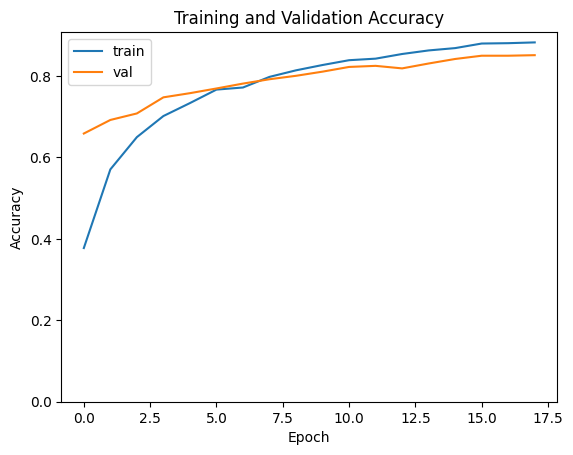

In [19]:
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')

plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['train', 'val'])
plt.ylim(ymin=0)

(0.0, 2.209579575061798)

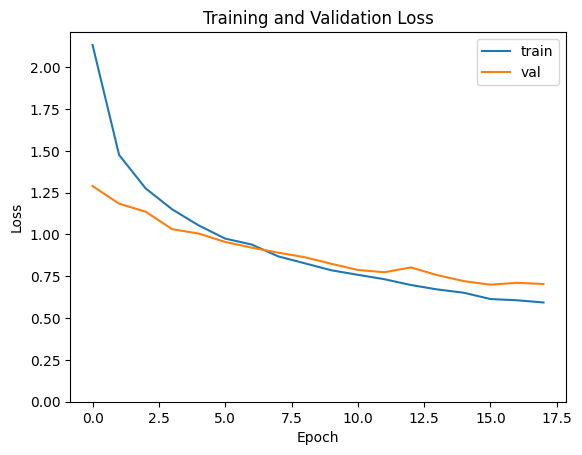

In [20]:
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')

plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['train', 'val'])
plt.ylim(ymin=0)

## Konversi Model

### Save to SavedModel

In [21]:
export_dir = 'saved_model/'
tf.saved_model.save(model, export_dir)

### Save to TF-Lite

In [22]:
converter = tf.lite.TFLiteConverter.from_saved_model(export_dir)
tflite_model = converter.convert()

os.makedirs('tflite', exist_ok=True)
tflite_model_file = pathlib.Path('tflite/vegs.tflite')
tflite_model_file.write_bytes(tflite_model)

210908

### Save to TFJS

In [31]:
model.save("model.h5")
!pip install tensorflowjs
!pip uninstall google-cloud-bigquery -y
!tensorflowjs_converter --input_format=keras model.h5 tfjs_model

2025-04-25 09:45:28.218206: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1745574328.257762   19585 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1745574328.267727   19585 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
🌲 Try https://ydf.readthedocs.io, the successor of TensorFlow Decision Forests with more features and faster training!
failed to lookup keras version from the file,
    this is likely a weight only file


In [34]:
!pip freeze requirements.txt

absl-py==1.4.0
accelerate==1.5.2
aiohappyeyeballs==2.6.1
aiohttp==3.11.15
aiosignal==1.3.2
alabaster==1.0.0
albucore==0.0.23
albumentations==2.0.5
ale-py==0.10.2
altair==5.5.0
annotated-types==0.7.0
anyio==4.9.0
argon2-cffi==23.1.0
argon2-cffi-bindings==21.2.0
array_record==0.7.1
arviz==0.21.0
astropy==7.0.1
astropy-iers-data==0.2025.4.21.0.37.6
astunparse==1.6.3
atpublic==5.1
attrs==25.3.0
audioread==3.0.1
autograd==1.7.0
babel==2.17.0
backcall==0.2.0
backports.tarfile==1.2.0
beautifulsoup4==4.13.4
betterproto==2.0.0b6
bigframes==2.1.0
bigquery-magics==0.9.0
bleach==6.2.0
blinker==1.9.0
blis==1.3.0
blosc2==3.3.1
bokeh==3.6.3
Bottleneck==1.4.2
bqplot==0.12.44
branca==0.8.1
CacheControl==0.14.2
cachetools==5.5.2
catalogue==2.0.10
certifi==2025.1.31
cffi==1.17.1
chardet==5.2.0
charset-normalizer==3.4.1
chex==0.1.89
clarabel==0.10.0
click==8.1.8
cloudpathlib==0.21.0
cloudpickle==3.1.1
cmake==3.31.6
cmdstanpy==1.2.5
colorcet==3.1.0
colorlover==0.3.0
colour==0.1.5
community==1.0.0b1
confect

In [35]:
!zip -r /content/submission_image_classification_model_deployment.zip /content/saved_model/ /content/tfjs_model/ /content/tflite/

  adding: content/saved_model/ (stored 0%)
  adding: content/saved_model/saved_model.pb (deflated 92%)
  adding: content/saved_model/fingerprint.pb (stored 0%)
  adding: content/saved_model/variables/ (stored 0%)
  adding: content/saved_model/variables/variables.index (deflated 77%)
  adding: content/saved_model/variables/variables.data-00000-of-00001 (deflated 9%)
  adding: content/saved_model/assets/ (stored 0%)
  adding: content/tfjs_model/ (stored 0%)
  adding: content/tfjs_model/group1-shard3of3.bin (deflated 7%)
  adding: content/tfjs_model/group1-shard2of3.bin (deflated 7%)
  adding: content/tfjs_model/group1-shard1of3.bin (deflated 8%)
  adding: content/tfjs_model/model.json (deflated 97%)
  adding: content/tflite/ (stored 0%)
  adding: content/tflite/vegs.tflite (deflated 81%)
